In [9]:
from ctypes import *
import time
from sys import path
from os import sep
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dwf = cdll.LoadLibrary("libdwf.so")
constants_path = "/usr/share/digilent/waveforms/samples/py"
path.append(constants_path)
import dwfconstants as constants

In [10]:
dwf.FDwfDeviceCloseAll()
filter_flags = c_int(constants.enumfilterType.value | constants.enumfilterUSB.value)
device_count = c_int()
dwf.FDwfEnum(filter_flags, byref(device_count))

hdwf = c_int()
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))
if hdwf.value == 0:
    raise RuntimeError("Failed to open device.")
print(hdwf.value)

dwf.FDwfAnalogIOReset(hdwf)
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(1), c_double(3.0)) #setting VDD = 3V
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(0), c_double(1))
dwf.FDwfAnalogIOEnableSet(hdwf, c_int(1))
time.sleep(0.5)

vpos = c_double()
dwf.FDwfAnalogIOStatus(hdwf)
dwf.FDwfAnalogIOChannelNodeStatus(hdwf, c_int(0), c_int(1), byref(vpos))
print(f"Power: +{vpos.value:.2f}V")

1
Power: +3.01V


In [11]:
DEVICE_ADDR = 0x52
ENABLE_REG = 0x80
ATIME_REG = 0x81
CONTROL_REG = 0x8F
CDATAL_REG = 0x94
CDATAH_REG = 0x95
RDATAL_REG = 0x96
RDATAH_REG = 0x97
GDATAL_REG = 0x98
GDATAH_REG = 0x99
BDATAL_REG = 0x9A
BDATAH_REG = 0x9B

def write_register(reg, value):
    iNak = c_int()
    rgTX = (c_ubyte * 2)(reg, value)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(2), byref(iNak))
    return iNak.value == 0

def read_register(reg):
    iNak = c_int()
    rgTX = (c_ubyte * 1)(reg)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(1), byref(iNak))
    if iNak.value == 0:
        rgRX = (c_ubyte * 1)()
        dwf.FDwfDigitalI2cRead(hdwf, c_int(DEVICE_ADDR), rgRX, c_int(1), byref(iNak))
        if iNak.value == 0:
            return rgRX[0]
    return None

dwf.FDwfDigitalI2cRateSet(hdwf, c_double(100e3))
dwf.FDwfDigitalI2cSclSet(hdwf, c_int(0))
dwf.FDwfDigitalI2cSdaSet(hdwf, c_int(1))
iNak = c_int()
dwf.FDwfDigitalI2cClear(hdwf, byref(iNak))

1

In [12]:
write_register(ENABLE_REG, 0x01) #Power on / PON = 1
time.sleep(0.01)
write_register(ENABLE_REG, 0x03) #Now, also RGBC enable / PON = 1, AEN = 1
write_register(ATIME_REG, 0xF6) #To run for 24ms, upto a max count of 10,240
write_register(CONTROL_REG, 0x02) #Setting AGAIN=16

True

In [13]:
#Function to test the sensor output
def read_colors():
    time.sleep(0.1)
    
    clear_low = read_register(CDATAL_REG)
    clear_high = read_register(CDATAH_REG)
    red_low = read_register(RDATAL_REG)
    red_high = read_register(RDATAH_REG)
    green_low = read_register(GDATAL_REG)
    green_high = read_register(GDATAH_REG)
    blue_low = read_register(BDATAL_REG)
    blue_high = read_register(BDATAH_REG)
    
    if all(val is not None for val in [clear_low, clear_high, red_low, red_high, green_low, green_high, blue_low, blue_high]):
        clear = (clear_high << 8) | clear_low
        red = (red_high << 8) | red_low
        green = (green_high << 8) | green_low
        blue = (blue_high << 8) | blue_low
        return {'clear': clear, 'red': red, 'green': green, 'blue': blue}
    return None

In [18]:
def cleanup():
    dwf.FDwfDeviceClose(hdwf)
    print("done!")

In [19]:
cleanup()
#call it everytime after work is done

done!


In [7]:
write_register(CONTROL_REG,3)
for i in range(256):
    atime_val = 255-i
    write_register(ATIME_REG,atime_val)
    colors = read_colors()

    # Calculating sleep time for python
    needed_time = (256 - atime_val) * 0.0024 
    time.sleep(needed_time)

    print(f"ATIME: {255-i}, Clear: {colors['clear']}, R: {colors['red']}, G: {colors['green']}, B: {colors['blue']}")

ATIME: 255, Clear: 291, R: 133, G: 109, B: 144
ATIME: 254, Clear: 626, R: 218, G: 324, B: 276
ATIME: 253, Clear: 1120, R: 335, G: 422, B: 362
ATIME: 252, Clear: 1500, R: 449, G: 560, B: 480
ATIME: 251, Clear: 1931, R: 544, G: 678, B: 582
ATIME: 250, Clear: 2310, R: 642, G: 799, B: 686
ATIME: 249, Clear: 2617, R: 785, G: 980, B: 839
ATIME: 248, Clear: 2978, R: 893, G: 1116, B: 957
ATIME: 247, Clear: 3419, R: 1023, G: 1280, B: 1064
ATIME: 246, Clear: 3698, R: 1110, G: 1386, B: 1188
ATIME: 245, Clear: 4015, R: 1207, G: 1505, B: 1290
ATIME: 244, Clear: 4474, R: 1348, G: 1684, B: 1442
ATIME: 243, Clear: 4786, R: 1437, G: 1794, B: 1537
ATIME: 242, Clear: 5225, R: 1567, G: 1918, B: 1644
ATIME: 241, Clear: 5547, R: 1665, G: 2071, B: 1774
ATIME: 240, Clear: 5957, R: 1787, G: 2232, B: 1918
ATIME: 239, Clear: 6412, R: 1920, G: 2401, B: 2057
ATIME: 238, Clear: 6835, R: 2046, G: 2559, B: 2191
ATIME: 237, Clear: 7104, R: 2130, G: 2662, B: 2280
ATIME: 236, Clear: 7488, R: 2245, G: 2795, B: 2394
ATIME

KeyboardInterrupt: 

--- Test 1.1: Linearity vs GAIN (All Channels) ---
Integration Time fixed at ~614ms. Starting Gain Sweep...
Gain:  1x | Clear:  1580, R:  474, G:  587, B:  511
Gain:  4x | Clear:  4717, R: 1408, G: 1754, B: 1517
Gain: 16x | Clear: 12909, R: 3856, G: 4810, B: 4147
Gain: 60x | Clear: 65535, R: 28667, G: 35819, B: 30692

Generating Plot...


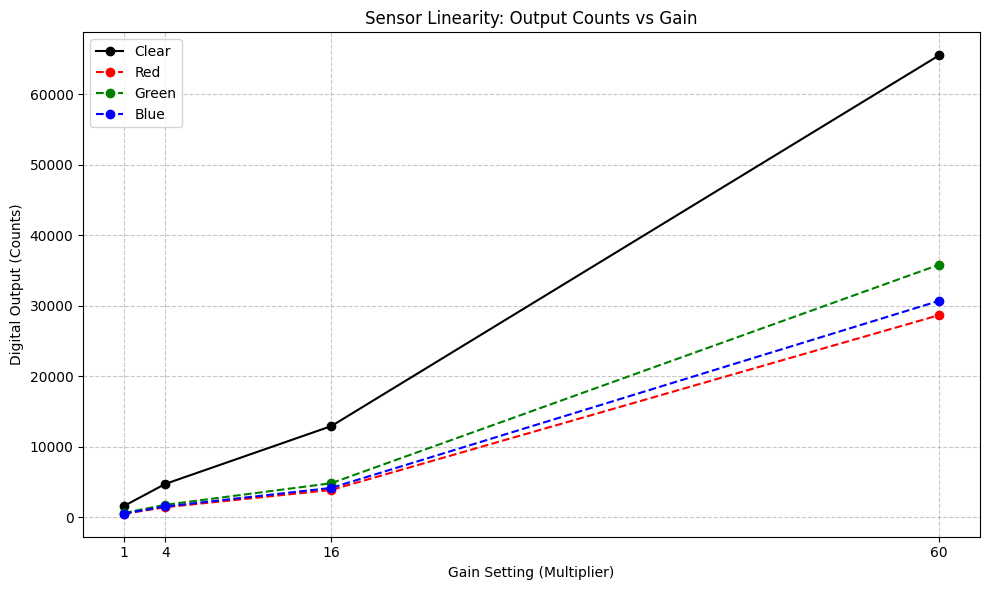

In [15]:
def test_1_1_linearity_gain():
    print("--- Test 1.1: Linearity vs GAIN (All Channels) ---")
    
    # 1. SETUP
    # Enable Power + ADC
    write_register(ENABLE_REG, 0x03)
    
    # Set CONSTANT Integration Time
    # We use 0x00 (Max Time ~614ms) to ensure 1x Gain isn't zero
    atime_setting = 0x00
    write_register(ATIME_REG, atime_setting)
    
    # Calculate Wait Time: (256 - 0) * 2.4ms = 614ms
    # Add buffer to ensure completion
    wait_time = (256 * 0.0024) + 0.1 
    
    # Define Gain Settings (Register Value -> Actual Multiplier)
    gain_settings = {
        0x00: 1,   # 1x
        0x01: 4,   # 4x
        0x02: 16,  # 16x
        0x03: 60   # 60x
    }
    
    # Lists to store data for plotting
    x_multipliers = []
    y_clear = []
    y_red = []
    y_green = []
    y_blue = []
    
    print(f"Integration Time fixed at ~614ms. Starting Gain Sweep...")
    
    # 2. SWEEP LOOP
    for reg_val, multiplier in gain_settings.items():
        # A. Set the Gain
        write_register(CONTROL_REG, reg_val)
        
        # B. Wait for new measurement
        # This is critical! If we don't wait, we read data from the previous gain.
        time.sleep(wait_time)
        
        # C. Read Data
        c = read_colors()
        
        if c:
            print(f"Gain: {multiplier:2d}x | Clear: {c['clear']:5d}, R: {c['red']:4d}, G: {c['green']:4d}, B: {c['blue']:4d}")
            
            x_multipliers.append(multiplier)
            y_clear.append(c['clear'])
            y_red.append(c['red'])
            y_green.append(c['green'])
            y_blue.append(c['blue'])

    # 3. PLOTTING
    print("\nGenerating Plot...")
    plt.figure(figsize=(10, 6))
    
    # Plot lines with markers 'o' to see the 4 distinct points
    plt.plot(x_multipliers, y_clear, 'k-o', label='Clear', linewidth=1.5)
    plt.plot(x_multipliers, y_red,   'r--o', label='Red')
    plt.plot(x_multipliers, y_green, 'g--o', label='Green')
    plt.plot(x_multipliers, y_blue,  'b--o', label='Blue')
    
    plt.title('Sensor Linearity: Output Counts vs Gain')
    plt.xlabel('Gain Setting (Multiplier)')
    plt.ylabel('Digital Output (Counts)')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Set X-axis ticks to match the exact gain steps
    plt.xticks([1, 4, 16, 60])
    
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the test
test_1_1_linearity_gain()

--- Master Test: ATIME Sweep across All Gains ---
Estimated Duration: ~5 minutes

--- Starting Sweep for Gain: 1x ---
......
--- Starting Sweep for Gain: 4x ---
......
--- Starting Sweep for Gain: 16x ---
......
--- Starting Sweep for Gain: 60x ---
......
Data Collection Complete.
Data saved to 'tcs34725_master_linearity.csv'


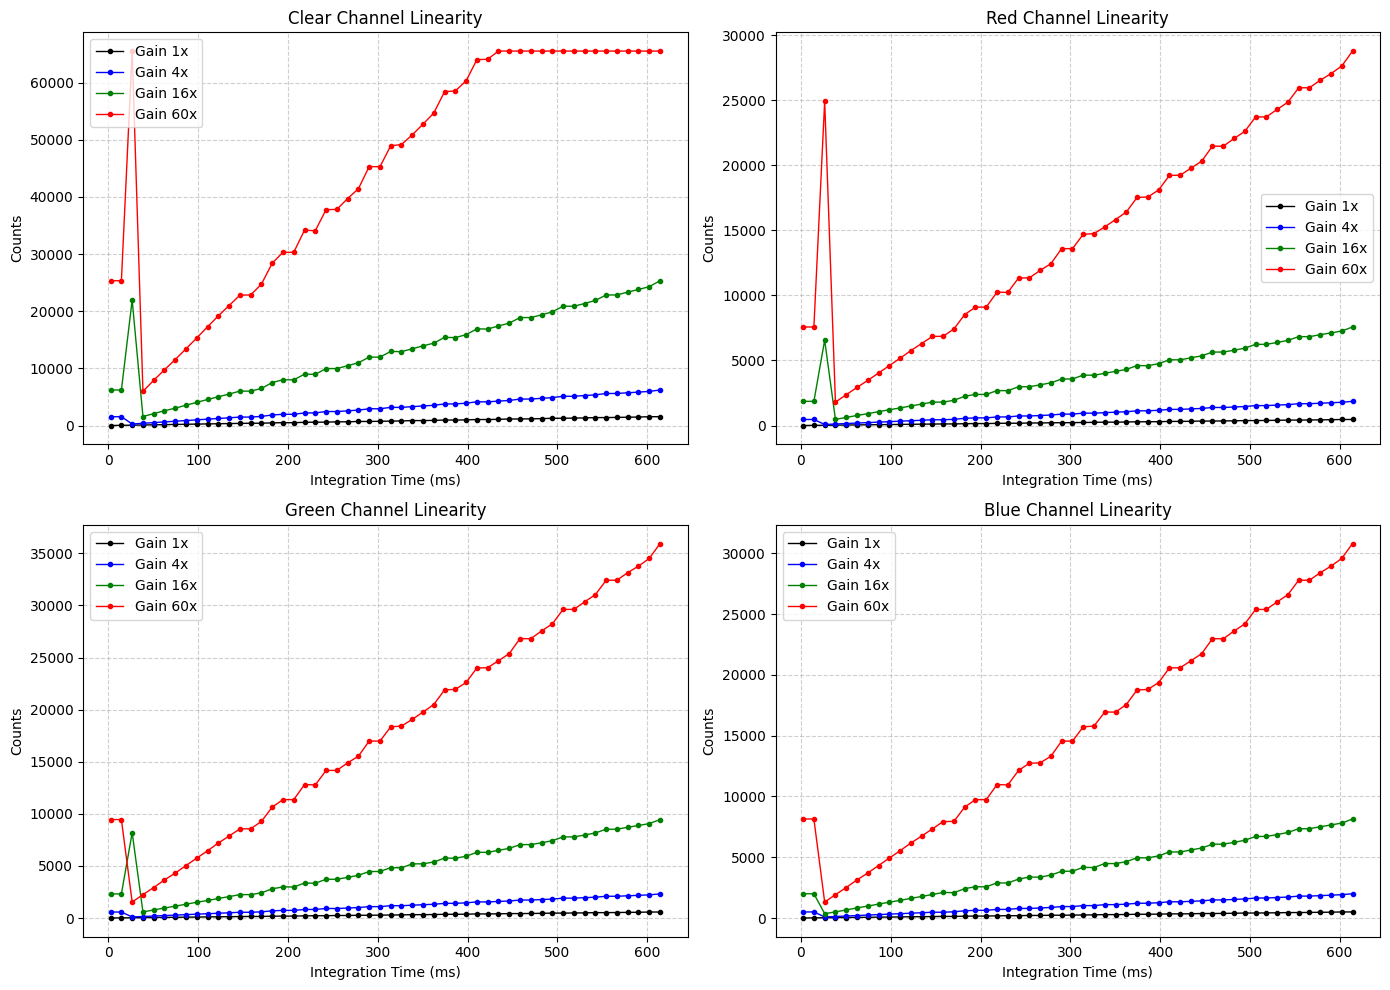

In [16]:
def test_master_linearity_sweep():
    print("--- Master Test: ATIME Sweep across All Gains ---")
    print("Estimated Duration: ~5 minutes")
    
    # 1. SETUP
    write_register(ENABLE_REG, 0x03) # Power + ADC Enable
    
    # Define Gains to test
    gains = {
        0x00: '1x',
        0x01: '4x',
        0x02: '16x',
        0x03: '60x'
    }
    
    # Storage
    all_data = []
    
    # 2. OUTER LOOP: Iterate through Gains
    for gain_reg, gain_label in gains.items():
        print(f"\n--- Starting Sweep for Gain: {gain_label} ---")
        
        # Set Gain
        write_register(CONTROL_REG, gain_reg)
        time.sleep(0.1) 
        
        # 3. INNER LOOP: Sweep ATIME (0 to 255)
        # Using step=5 to keep total test time reasonable (~1 min per gain)
        # Change step=1 for maximum resolution (will take ~5 mins total)
        for i in range(0, 256, 5):
            atime_reg = 255 - i
            write_register(ATIME_REG, atime_reg)
            
            # Calculate Integration Time & Wait
            integ_steps = 256 - atime_reg
            time_ms = integ_steps * 2.4
            
            # Wait time (dynamic)
            wait_sec = (time_ms / 1000.0) + 0.015
            time.sleep(wait_sec)
            
            c = read_colors()
            if c:
                row = {
                    'Gain': gain_label,
                    'ATIME_Register': atime_reg,
                    'Time_ms': time_ms,
                    'Clear': c['clear'],
                    'Red': c['red'],
                    'Green': c['green'],
                    'Blue': c['blue']
                }
                all_data.append(row)
                
            # Progress dot
            if i % 50 == 0: print(".", end="", flush=True)
            
    print("\nData Collection Complete.")
    
    # 4. DATA PROCESSING
    df = pd.DataFrame(all_data)
    
    # Export to CSV for safekeeping
    df.to_csv('tcs34725_master_linearity.csv', index=False)
    print("Data saved to 'tcs34725_master_linearity.csv'")
    
    # 5. PLOTTING (4 Subplots)
    channels = ['Clear', 'Red', 'Green', 'Blue']
    colors_map = {'1x':'black', '4x':'blue', '16x':'green', '60x':'red'}
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten() # Make 2D array 1D for easy iteration
    
    for idx, channel in enumerate(channels):
        ax = axes[idx]
        
        # Plot a line for each Gain
        for gain_label, color in colors_map.items():
            # Filter data for this specific Gain
            subset = df[df['Gain'] == gain_label]
            
            ax.plot(subset['Time_ms'], subset[channel], 
                    marker='.', linestyle='-', linewidth=1, label=f"Gain {gain_label}", color=color)
        
        ax.set_title(f'{channel} Channel Linearity')
        ax.set_xlabel('Integration Time (ms)')
        ax.set_ylabel('Counts')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()
        
    plt.tight_layout()
    plt.show()
    
    return df

# Run the Master Test
df_master = test_master_linearity_sweep()